In [23]:

import numpy as np
import astropy.units as u
from datetime import datetime
today = int(datetime.today().strftime('%Y%m%d'))
from importlib import reload
from astropy.io import fits
import copy
import time
from datetime import timezone 

import ray

import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm, Normalize, CenteredNorm
from matplotlib.patches import Circle, Rectangle
from matplotlib.gridspec import GridSpec

import esc_llowfsc_sim
from esc_llowfsc_sim.math_module import xp, xcipy, ensure_np_array
from esc_llowfsc_sim import utils, detector, dm, wfe
import esc_llowfsc_sim.esc_fraunhofer as esc
from esc_llowfsc_sim import llowfsc_sim_rt as llowfsc
from esc_llowfsc_sim import shmim_utils

from magpyx.utils import ImageStream

model_params = utils.load_pickle(esc_llowfsc_sim.path/'data/example_fraunhofer_params_1K.pkl')


# Load in the desired calibration data so we can close compute a control matrix ($P$) and close the loop.

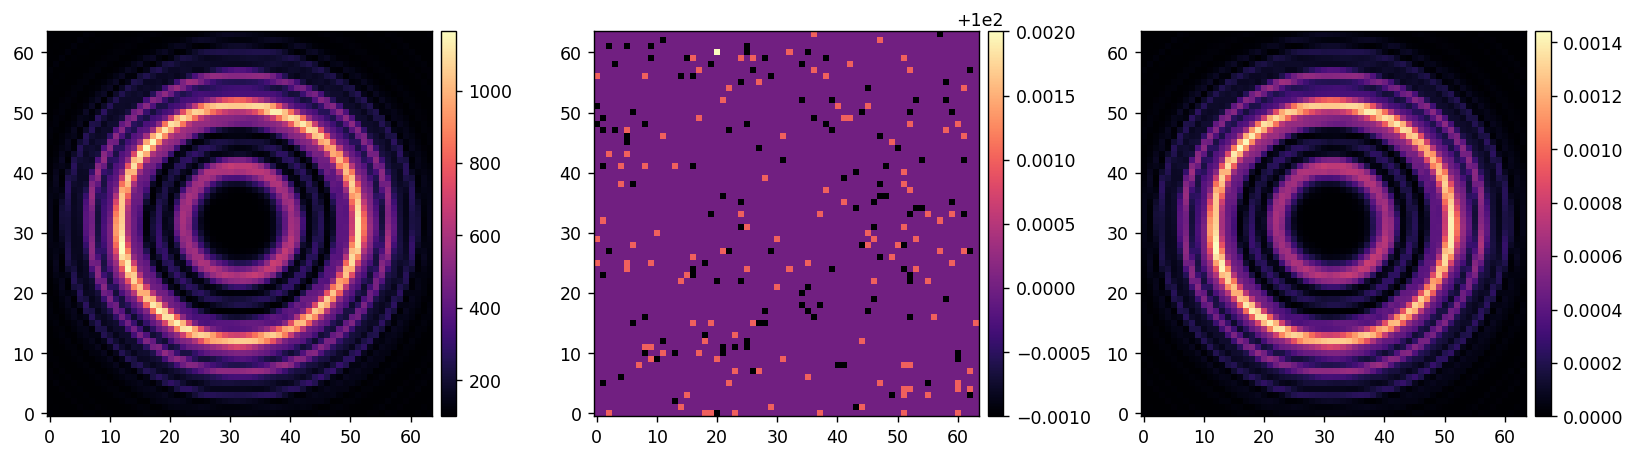

In [34]:
# calib_data = utils.load_pickle('flight-sim-data/starting_calibration.pkl')
calib_data = utils.load_pickle('flight-sim-data-1K/ground_calibration_2.pkl')
calib_mag = calib_data['calib_mag']
camlo_ref_im = ensure_np_array( calib_data['ref_image'])
ref_dark = ensure_np_array( calib_data['ref_dark'] )
ref_im_flux_norm = ensure_np_array( calib_data['ref_im_flux_norm'])
zernike_modes = ensure_np_array(calib_data['zer_modes'])
zer_modal_matrix = ensure_np_array(calib_data['zer_modal_matrix'])
zer_rm = ensure_np_array( calib_data['zer_response_matrix'] )
zer_rc = ensure_np_array( calib_data['zer_response_cube'] )
dm_mask = ensure_np_array(calib_data['dm_mask'])
llowfsc_mask = ensure_np_array(calib_data['llowfsc_mask'])

Nmodes = zer_rm.shape[1]
P = ensure_np_array(utils.TikhonovInverse(xp.array(zer_rm), 0))

utils.imshow(
    [camlo_ref_im, ref_dark, ref_im_flux_norm]
)

# Make the required SHMIMs (in case they don't already exist).

In [26]:

shmim_utils.create_shmim('llowfscrefim', (64,64))
shmim_utils.create_shmim('llowfscgains', (Nmodes,1))
shmim_utils.create_shmim('fsm02offset', (3, 1))
shmim_utils.create_shmim('dm00disp02offset', (Nmodes,1))
shmim_utils.create_shmim('dm00disp03offset', (Nmodes,1))

CAMLO_STREAM = ImageStream('camlosim')
FSM1_STREAM = ImageStream('fsm01')
DM1_STREAM = ImageStream('dm00disp01')
LLOWFSC_REF_STREAM = ImageStream('llowfscrefim')
LLOWFSC_GAINS_STREAM = ImageStream('llowfscgains')

LLOWFSC_REF_STREAM.write(ref_im_flux_norm)
shmim_utils.write(2*[0.5] + (Nmodes-2)*[0.05], LLOWFSC_GAINS_STREAM)

FSM2_OFFSET_STREAM = ImageStream('fsm02offset')
DM2_OFFSET_STREAM = ImageStream('dm00disp02offset')
DM3_OFFSET_STREAM = ImageStream('dm00disp03offset')
OFFSET_STREAMS = [DM2_OFFSET_STREAM, DM3_OFFSET_STREAM]

In [28]:
shmim_utils.write(2*[0.5] + (Nmodes-2)*[0.01], LLOWFSC_GAINS_STREAM)

In [66]:
reload(llowfsc)
reload(shmim_utils)
try:
    print('Running LLOWFSC simulator continuously ...')
    while 1:
        # compute_llowfsc_standard(P, llowfsc_mask, zernike_modes,)
        # compute_llowfsc_ref_offset(P, llowfsc_mask, zernike_modes[2:],)
        # compute_llowfsc_ff_offset(P, llowfsc_mask, zernike_modes[2:], 100.0, camlo_ref_im[llowfsc_mask].sum())
        llowfsc.compute_llowfsc_ff_offset(
            CAMLO_STREAM,
            FSM1_STREAM,
            DM1_STREAM,
            LLOWFSC_REF_STREAM,
            LLOWFSC_GAINS_STREAM,
            OFFSET_STREAMS,
            P, 
            llowfsc_mask, 
            zernike_modes[2:], 
            model_params['fsm_beam_diam'],
            ref_dark,
            flux_coeff=1,
            leakage=0.0,
        )
except KeyboardInterrupt:
    shmim_utils.zero([FSM1_STREAM, DM1_STREAM])
    # DM_STREAM.write(np.zeros(DM_STREAM1.shape))
    print('LLOWFSC simulator terminated.')

Running LLOWFSC simulator continuously ...
LLOWFSC simulator terminated.


[ 1.54913485e-09  5.31482460e-09 -7.55155541e-09  2.99469362e-11
  1.73281124e-09  2.85438386e-09  6.44752928e-10 -1.33863974e-10
  4.08690296e-09 -5.16240810e-09  2.00715073e-09 -1.02550650e-09
  7.20508769e-10  1.46740670e-09  7.03566466e-10  3.12468212e-09
  3.91112812e-09 -1.21139063e-09 -1.23393804e-09 -4.26275513e-10]


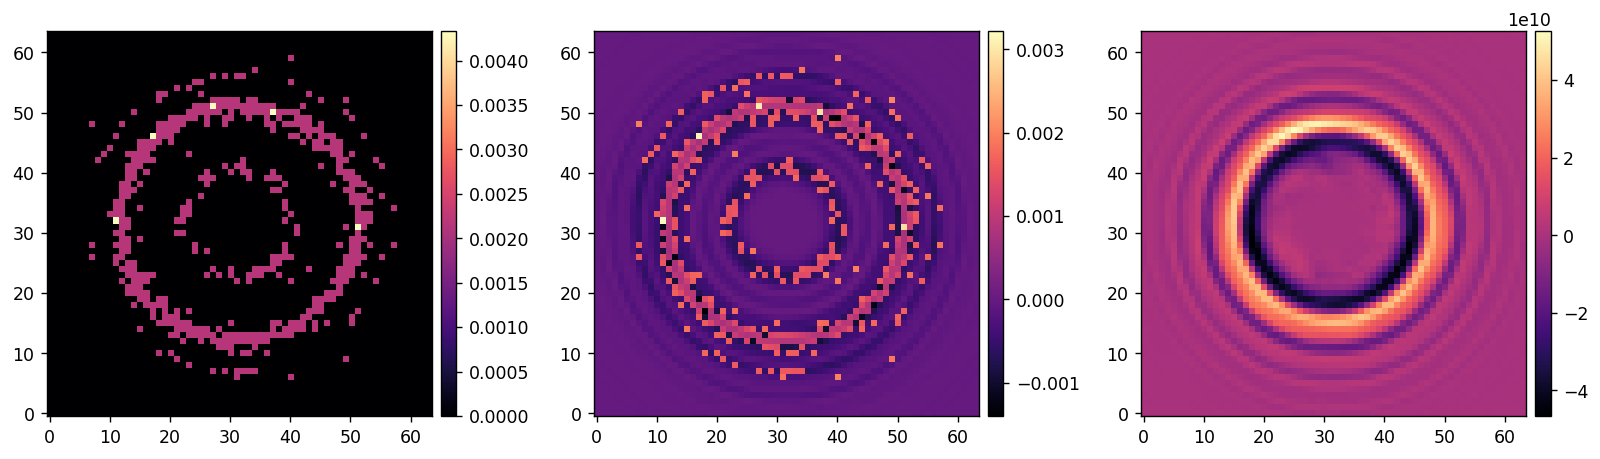

In [82]:
camlo_im = shmim_utils.stack(CAMLO_STREAM, 1) - ref_dark
camlo_im /= camlo_im.sum()
del_im = camlo_im - ref_im_flux_norm

coeff = P.dot(del_im[llowfsc_mask])
print(coeff)

utils.imshow([camlo_im, del_im, zer_rc[9]])

[ 7.00837026e-10  3.20346811e-10 -7.80226022e-09  1.20791940e-09
  6.26668458e-10 -1.28059190e-09 -3.06808666e-10 -1.13550660e-10
 -3.60532146e-10 -6.35457100e-09  2.20408877e-10  6.94769226e-10
 -5.32136639e-10 -1.96942330e-09 -6.39455282e-10  1.89692325e-10
 -1.28904751e-09 -3.33601115e-10  2.44105164e-09 -1.91483509e-09]


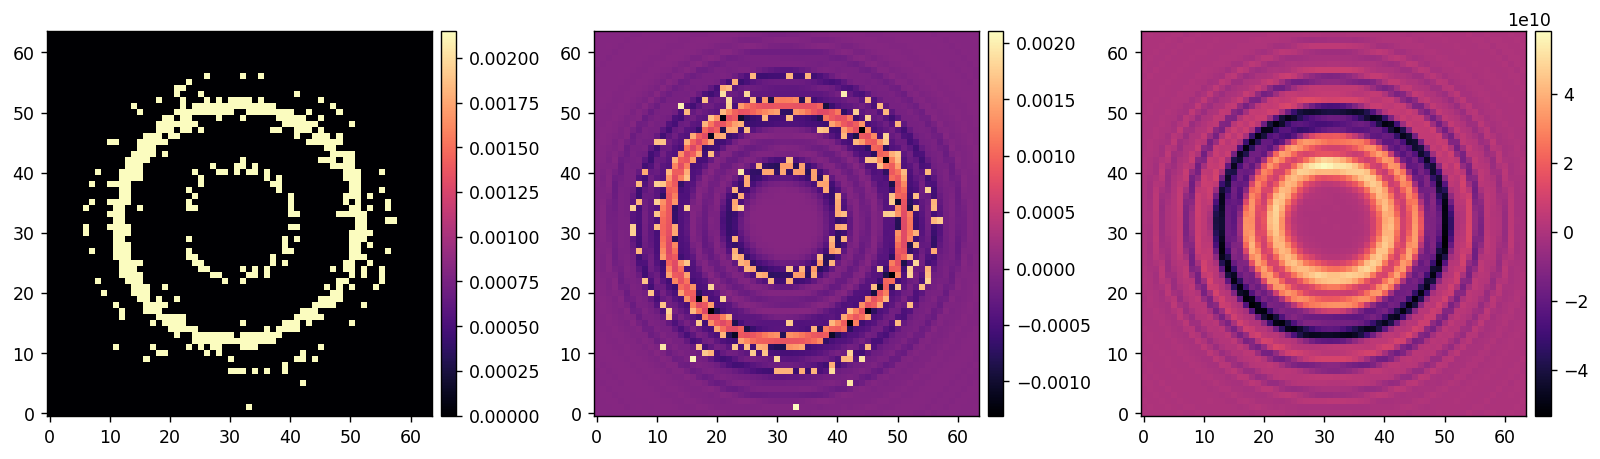

In [68]:
camlo_im = shmim_utils.stack(CAMLO_STREAM, 1) - ref_dark
camlo_im /= camlo_im.sum()
del_im = camlo_im - ref_im_flux_norm

coeff = P.dot(del_im[llowfsc_mask])
print(coeff)

utils.imshow([camlo_im, del_im, zer_rc[2]])

[ 3.53228489e-09  1.81805441e-09 -2.55541781e-10 -2.50871565e-11
  2.72808461e-10  1.04154221e-09  2.10966728e-09 -7.03103165e-10
  3.88472041e-10 -5.80153877e-10  2.10590621e-12 -4.72248125e-10
  8.21113155e-11  2.04885236e-10  2.00968167e-09  1.03943510e-09
  3.81344322e-10 -1.17233515e-09 -1.89813909e-10 -8.18045602e-10]


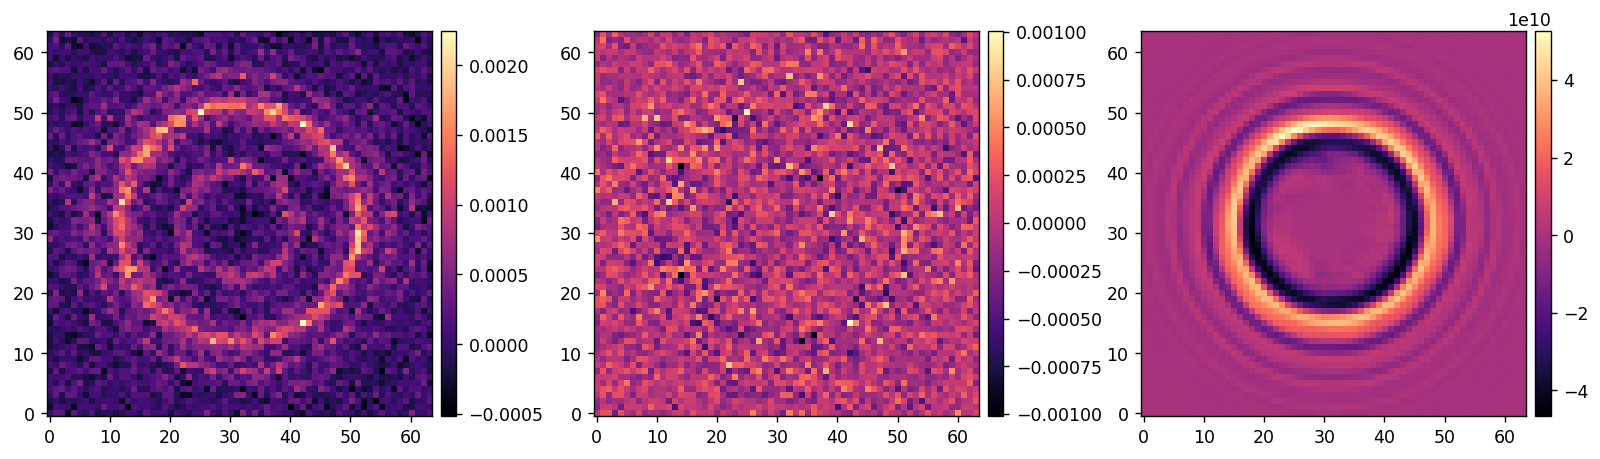

In [83]:
camlo_im = shmim_utils.stack(CAMLO_STREAM, 1) - ref_dark
camlo_im /= camlo_im.sum()
del_im = camlo_im - ref_im_flux_norm

coeff = P.dot(del_im[llowfsc_mask])
print(coeff)

utils.imshow([camlo_im, del_im, zer_rc[9]])